In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import math

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
! rm -r /root/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
! mkdir /root/.kaggle

In [ ]:
! cp /content/drive/MyDrive/ColabNotebooks/DeepLearning/kaggle.json /root/.kaggle

In [ ]:
import kaggle

In [ ]:
! kaggle competitions download -c plant-pathology-2020-fgvc7

 99% 769M/779M [00:10<00:00, 70.5MB/s]
100% 779M/779M [00:10<00:00, 80.4MB/s]


In [ ]:
! unzip -q plant-pathology-2020-fgvc7.zip

# 1.	A Plant Pathology client is working on identifying diseases impacting agricultural crops. They have a dataset of crop images with labels of diseases impacting them. Dataset can be found here: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview
## a.	Create an EDA report for the above stated problem, outlining what & why of your approach?


In [ ]:
train_labels = pd.read_csv("train.csv")
#test_labels = pd.read_csv("test.csv")
#submit = pd.read_csv("sample_submission.csv")

In [ ]:
train_labels.sample(5)

In [ ]:
image_shape = []

### Healthy Leaves

In [ ]:
# Show image samples
#-----------------------------------------

def show_sample_images(label):
  plt.figure(figsize=(15, 8))

  for index, file in enumerate(train_labels[train_labels[label]== 1]["image_id"].sample(15)):
    plt.subplot(3, 5, index+1)
    image = cv2.cvtColor(cv2.imread("images/"+ file+ ".jpg"), cv2.COLOR_BGR2RGB)
    image_shape.append(image.shape)
    plt.imshow(image)
  plt.show()

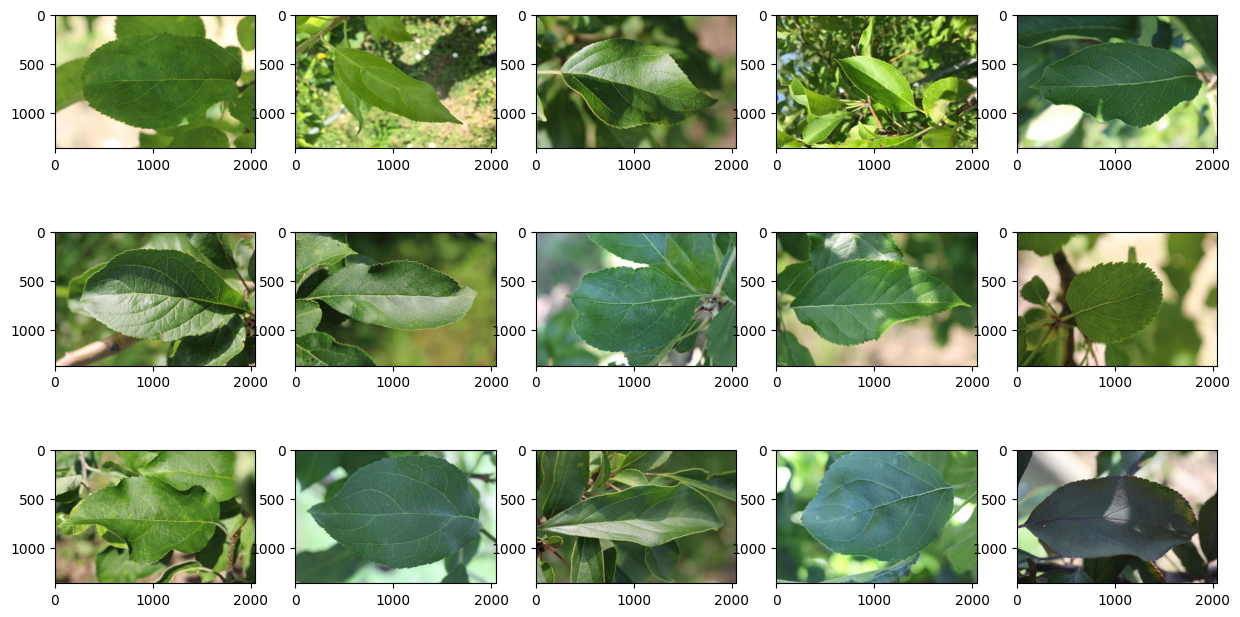

In [ ]:
# healthy leaves

show_sample_images("healthy")

### Leaves with rust

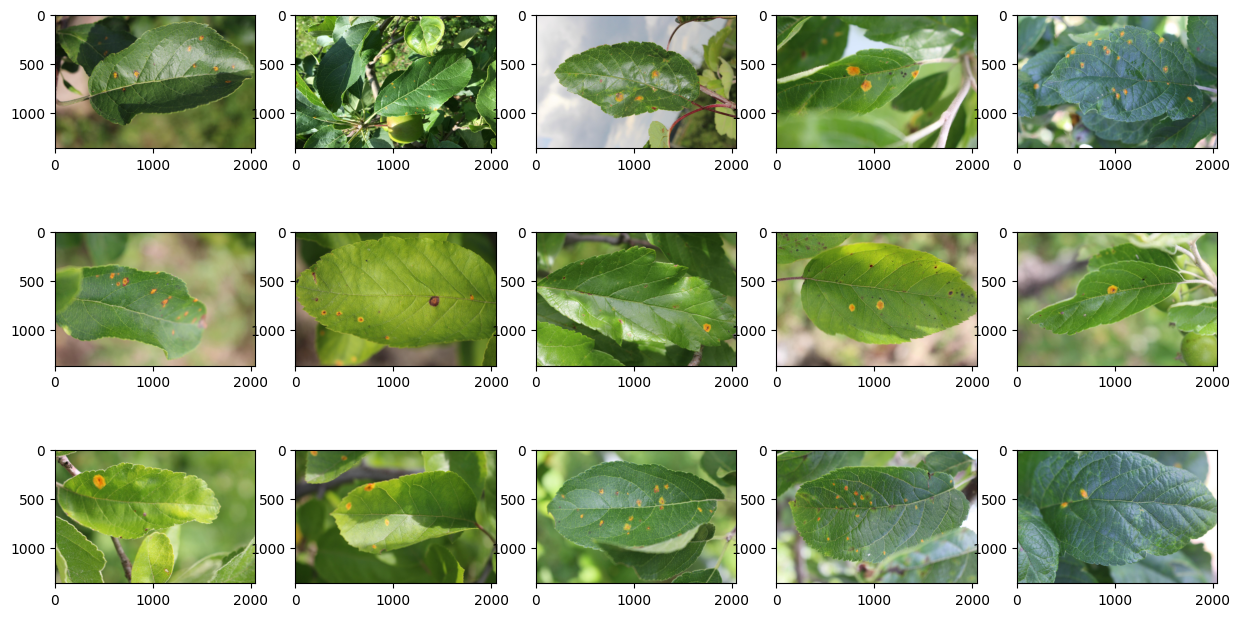

In [ ]:
# rusty leaves

show_sample_images("rust")

### Leaves with scab

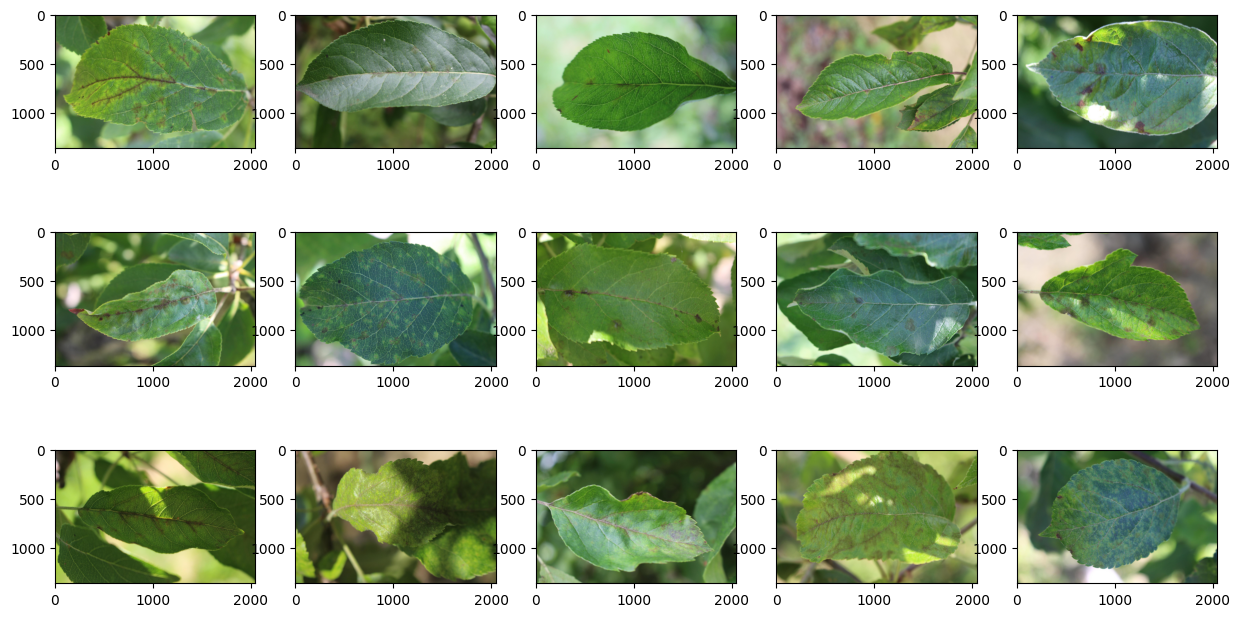

In [ ]:
# scaby leaves

show_sample_images("scab")

### Leaves with multiple diseases

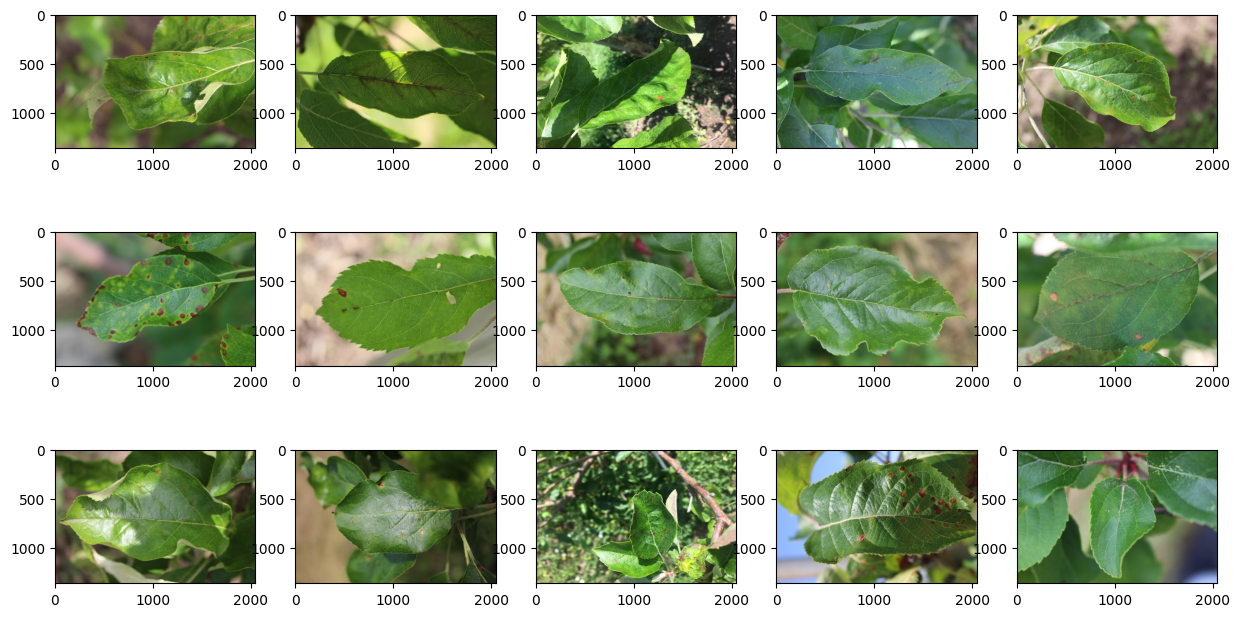

In [ ]:
# multiple diseases leaves

show_sample_images("multiple_diseases")

# Data Preparation

## Image Shape Distribution

All images are of same shape (1365, 2046, 3)

In [ ]:
image_shape[:5]

[(1365, 2048, 3),
 (1365, 2048, 3),
 (1365, 2048, 3),
 (1365, 2048, 3),
 (1365, 2048, 3)]

## Data Distribution

In [ ]:
print("Total Number of Leave images : ", train_labels.shape[0])
print("Total Number of Healthy leaves : ", train_labels.healthy.value_counts()[1])
print("Total Number of rusty leaves : ", train_labels.rust.value_counts()[1])
print("Total Number of scaby leaves : ", train_labels.scab.value_counts()[1])
print("Total Number of leaves with multiple diseases: ", train_labels.multiple_diseases.value_counts()[1])

Total Number of Leave images :  1821
Total Number of Healthy leaves :  516
Total Number of rusty leaves :  622
Total Number of scaby leaves :  592
Total Number of leaves with multiple diseases:  91


# What and Why of my approach
1. The data is not unifort for all fout classes
2. Image data for multiple diseases is much smaller in comparision to the other classes
3. Overall data is very small.

I will try different models with transfer learning and ensemble method becouse of the complexity of the problem. Since the training data is significantly small I will use image augmentation to created artificial data for the training.

# 2.	A Plant Pathology client is working on identifying diseases impacting agricultural crops. They have a dataset of crop images with labels of diseases impacting them. But the client is unable to provide more images (as requested by you) for training:
a.	What is the typical routine you will follow here (when data is scarce)?
b.	What are the basic augmentation techniques you can follow here, please explain how and why they are useful (for plant leaf images) ?  
c.	Try to use augmentation packages other than ImagDataGenerator from keras, example - `imgaug`


In [ ]:
train_labels["filename"] = train_labels["image_id"] + ".jpg"
train_labels["class"] = (train_labels.iloc[:, 1:] == 1).idxmax(1)

In [ ]:
train_labels.sample(5)

image_id  healthy  multiple_diseases  rust  scab        filename  \
311    Train_311        1                  0     0     0   Train_311.jpg   
1128  Train_1128        0                  0     0     1  Train_1128.jpg   
816    Train_816        0                  0     1     0   Train_816.jpg   
1640  Train_1640        0                  0     1     0  Train_1640.jpg   
1594  Train_1594        0                  0     1     0  Train_1594.jpg   

        class  
311   healthy  
1128     scab  
816      rust  
1640     rust  
1594     rust

# 3.	Iterate over and try different architecture and topologies and preserve the results of each experiment using TensorBoard. Also, save major metrics in an Excel (or try W&B).

## 🚀 Install, Import and Login

In [ ]:
!pip install -qq -U wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger
from wandb.keras import WandbModelCheckpoint

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def get_dataset(b_size= 32, imgsize=250, model_type="mymodel"):
  scale = 1
  if model_type == "mymodel":
    scale = 255
  else :
    scale = 1

  Idg = tf.keras.preprocessing.image.ImageDataGenerator(
          validation_split=0.1,
          rotation_range=30,
          width_shift_range=0.2,
          height_shift_range=0.2,
          rescale=1./scale,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')

  train_gen = Idg.flow_from_dataframe(train_labels, "images", x_col= "filename", y_col="class",
                                      batch_size=b_size, target_size=(imgsize, imgsize), subset="training")

  val_gen = Idg.flow_from_dataframe(train_labels, "images", x_col= "filename", y_col="class",
                                      batch_size=b_size, target_size=(imgsize, imgsize), subset="validation")

  return train_gen, val_gen

# Models

## My model

In [ ]:
def get_mymodel(input, input_shape):
  conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu') (input)
  pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid') (conv1)

  conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu') (pool1)
  pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid') (conv2)

  conv3 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu') (pool2)
  pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid') (conv3)

  mymodel_avg = tf.keras.layers.GlobalAveragePooling2D() (pool3)

  return mymodel_avg

## VGG16

In [ ]:
# VGG
def get_vgg16(input, input_shape):
  # Pre Processing is acting in a custom Layer using Lambda
  vgg_data_pre = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input) (input)
  # Downloading the VGG16 model without the cat layers
  vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape= input_shape + (3,), )
  # Make the layers non trainable & sustaining the original VGG weights
  vgg_model.trainable = False
  # Activate the model, by taking input from Pre Processing Layer
  vgg = vgg_model (vgg_data_pre)
  #
  vgg_avg = tf.keras.layers.GlobalAveragePooling2D()(vgg)
  return vgg_avg


## Resnet50

In [ ]:
# RESNET
def get_resnet50(input, input_shape):
  resnet_data_pre = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input) (input)
  resnet_model = tf.keras.applications.resnet50.ResNet50(include_top = False, input_shape = input_shape + (3,))
  resnet_model.trainable = False
  resnet = resnet_model (resnet_data_pre)
  resnet_avg = tf.keras.layers.GlobalAveragePooling2D() (resnet)
  return resnet_avg


## Top Layer

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
def get_toplayer(bot_layer, dropouts, model_type="mymodel", hidden_layer=None, classes = 4):
  if model_type == "ensemble":
    concat = tf.keras.layers.Concatenate() (bot_layer)
  else:
    concat = bot_layer

  bn = tf.keras.layers.BatchNormalization() (concat)

  if hidden_layer != None :
    dense = tf.keras.layers.Dense(hidden_layer, activation="relu", activity_regularizer=l2(0.001)) (bn)
    bn2 = tf.keras.layers.BatchNormalization() (dense)
  else:
    bn2 = bn

  dropout = tf.keras.layers.Dropout(dropouts) (bn2)
  output = tf.keras.layers.Dense(classes, activation='softmax', activity_regularizer=l2(0.001)) (dropout)

  return output

## Defining the Model

In [ ]:
def full_model(imgsize, dropouts=0.2, model_type="mymodel", hidden_layer=None, classes = 4):
  input_shape = (imgsize, imgsize)
  input = tf.keras.layers.Input(input_shape + (3,))

  if model_type == "mymodel" :
    bot_layer = get_mymodel(input, input_shape)
  elif model_type == "vgg" :
    bot_layer = get_vgg16(input, input_shape)
  elif model_type == "resnet" :
    bot_layer = get_resnet50(input, input_shape)
  elif model_type == "ensemble" :
    bot_layer = [get_vgg16(input, input_shape), get_resnet50(input, input_shape)]
  else :
    print("! Warning : invalig model type. We are moving ahead with mymodel")
    bot_layer = get_mymodel(input, input_shape)

  output = get_toplayer(bot_layer, dropouts, model_type, hidden_layer, classes)

  final_model = tf.keras.models.Model(inputs=[input], outputs=[output])

  return final_model


In [ ]:
 F1 = full_model(240)
F1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624  

## Optimizers

In [ ]:
def get_optimizer(lr=1e-3, optimizer="adam"):
  "Select optmizer between adam and sgd with momentum"
  if optimizer.lower() == "adam":
      return tf.keras.optimizers.Adam(learning_rate=lr)
  if optimizer.lower() == "sgd":
      return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5)



## Training

In [ ]:
def train(model, train_gen, val_gen, b_size=32, epochs=10, lr=1e-3, optimizer='adam', log_freq=1):

    # Compile model like you usually do.
    tf.keras.backend.clear_session()
    model.compile(loss="categorical_crossentropy",
                  optimizer=get_optimizer(lr, optimizer),
                  metrics=["accuracy"])

    # callback setup
    EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=log_freq),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
        EarlyStop_callback
    ]

    model.fit(train_gen,
              batch_size = b_size,
              epochs=epochs,
              validation_data=val_gen,
              callbacks=wandb_callbacks)

    return model

## Defining Sweep

In [ ]:
# Search method (Grid, Random, Bayes)
sweep_config = {
    'method': 'grid'
    }

# Hyperparameters
parameters_dict = {
    'optimizer': {
        'value': 'adam'
        },
    'dropout': {
          'value': 0.3
        },
    }

parameters_dict.update({
    'epochs': {
        'value': 30}
    })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        #'distribution': 'uniform',
        #'min': 0.001,
        #'max': 0.005
        #"values": [0.001, 0.002, 0.003]
        "value" : 0.001
      },
    'batch_size': {
        #'values': [32, 64]
        "value" : 64
      },
    'model_type' : {
        "value" :  "ensemble"
      }
    })

sweep_config['parameters'] = parameters_dict



## The Sweep Training Loop

In [ ]:
def sweep_train(config_defaults=None, arch_name="ConvNet", data_name="Plant-disease"):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = arch_name
        wandb.config.dataset_name = data_name

        # initialize model
        model = full_model(imgsize = 350, dropouts= wandb.config.dropout, model_type=wandb.config.model_type, hidden_layer=50, classes = 4)

        train_gen, val_gen = get_dataset(b_size=wandb.config.batch_size, imgsize = 350, model_type=wandb.config.model_type)

        model = train(model,
                      train_gen,
                      val_gen,
                      wandb.config.batch_size,
                      wandb.config.epochs,
                      wandb.config.learning_rate,
                      wandb.config.optimizer)


## Initialize Sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-keras")

wandb.agent(sweep_id, function=sweep_train, count=12)

wandb: Network error (ReadTimeout), entering retry loop.


Create sweep with ID: sdsu1ep3
Sweep URL: https://wandb.ai/shashankjt362/sweeps-keras/sweeps/sdsu1ep3


wandb: Agent Starting Run: s89ilj4c with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	model_type: ensemble
wandb: 	optimizer: adam
wandb: Currently logged in as: shashankjt362. Use `wandb login --relogin` to force relogin


94765736/94765736 [==============================] - 1s 0us/step
Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 0.9440 - accuracy: 0.6632

wandb: Adding directory to artifact (./my_model_01)... Done. 0.5s


26/26 [==============================] - 232s 8s/step - loss: 0.9440 - accuracy: 0.6632 - val_loss: 0.7125 - val_accuracy: 0.7308
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8395

wandb: Adding directory to artifact (./my_model_02)... Done. 2.9s


26/26 [==============================] - 159s 6s/step - loss: 0.4570 - accuracy: 0.8395 - val_loss: 0.5119 - val_accuracy: 0.8516
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8572

wandb: Adding directory to artifact (./my_model_03)... Done. 0.5s


26/26 [==============================] - 154s 6s/step - loss: 0.3982 - accuracy: 0.8572 - val_loss: 0.4307 - val_accuracy: 0.8626
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.8768

wandb: Adding directory to artifact (./my_model_04)... Done. 0.5s


26/26 [==============================] - 159s 6s/step - loss: 0.3468 - accuracy: 0.8768 - val_loss: 0.4043 - val_accuracy: 0.8791
Epoch 5/30
26/26 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8896

wandb: Adding directory to artifact (./my_model_05)... Done. 0.5s


26/26 [==============================] - 152s 6s/step - loss: 0.3272 - accuracy: 0.8896 - val_loss: 0.3800 - val_accuracy: 0.8956
Epoch 6/30
26/26 [==============================] - ETA: 0s - loss: 0.2771 - accuracy: 0.9030

wandb: Adding directory to artifact (./my_model_06)... Done. 0.5s


26/26 [==============================] - 152s 6s/step - loss: 0.2771 - accuracy: 0.9030 - val_loss: 0.4103 - val_accuracy: 0.8626
Epoch 7/30
26/26 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.9109

wandb: Adding directory to artifact (./my_model_07)... Done. 4.0s


26/26 [==============================] - 165s 6s/step - loss: 0.2481 - accuracy: 0.9109 - val_loss: 0.3518 - val_accuracy: 0.8901
Epoch 8/30
26/26 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9109

wandb: Adding directory to artifact (./my_model_08)... Done. 0.5s


26/26 [==============================] - 153s 6s/step - loss: 0.2420 - accuracy: 0.9109 - val_loss: 0.3373 - val_accuracy: 0.8681
Epoch 9/30
26/26 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9140

wandb: Adding directory to artifact (./my_model_09)... Done. 2.3s


26/26 [==============================] - 155s 6s/step - loss: 0.2417 - accuracy: 0.9140 - val_loss: 0.3428 - val_accuracy: 0.8846
Epoch 10/30
26/26 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9347

wandb: Adding directory to artifact (./my_model_10)... Done. 0.9s


26/26 [==============================] - 152s 6s/step - loss: 0.1935 - accuracy: 0.9347 - val_loss: 0.3101 - val_accuracy: 0.9066
Epoch 11/30
26/26 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9329

wandb: Adding directory to artifact (./my_model_11)... Done. 0.6s


26/26 [==============================] - 153s 6s/step - loss: 0.2011 - accuracy: 0.9329 - val_loss: 0.3076 - val_accuracy: 0.8791
Epoch 12/30
26/26 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9402

wandb: Adding directory to artifact (./my_model_12)... Done. 0.5s


26/26 [==============================] - 154s 6s/step - loss: 0.1746 - accuracy: 0.9402 - val_loss: 0.2664 - val_accuracy: 0.9121
Epoch 13/30
26/26 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9433

wandb: Adding directory to artifact (./my_model_13)... Done. 0.5s


26/26 [==============================] - 153s 6s/step - loss: 0.1605 - accuracy: 0.9433 - val_loss: 0.2917 - val_accuracy: 0.8956
Epoch 14/30
26/26 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9433

wandb: Adding directory to artifact (./my_model_14)... Done. 0.7s


26/26 [==============================] - 153s 6s/step - loss: 0.1626 - accuracy: 0.9433 - val_loss: 0.3201 - val_accuracy: 0.8901
Epoch 15/30
21/26 [=======================>......] - ETA: 21s - loss: 0.1391 - accuracy: 0.9538

# Final Training after Hyperparameter Tuning

In [ ]:
with wandb.init(config=None):  # this gets over-written in the Sweep

  # Specify the other hyperparameters to the configuration, if any
  wandb.config.architecture_name = "Final Model"
  wandb.config.dataset_name = "Plant Pathology"

  model = full_model(imgsize = 350, dropouts= 0.3, model_type="ensemble", hidden_layer=50, classes = 4)

  train_gen, val_gen = get_dataset(b_size=64, imgsize = 350, model_type="ensemble")


  Final_model = train(model, train_gen, val_gen, 64, 50, 0.001, "adam")

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.1318 - accuracy: 0.6364

wandb: Adding directory to artifact (./my_model_01)... Done. 0.5s


26/26 [==============================] - 239s 8s/step - loss: 1.1318 - accuracy: 0.6364 - val_loss: 0.6977 - val_accuracy: 0.7967
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.8170

wandb: Adding directory to artifact (./my_model_02)... Done. 0.5s


26/26 [==============================] - 172s 7s/step - loss: 0.6282 - accuracy: 0.8170 - val_loss: 0.6184 - val_accuracy: 0.8132
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.5197 - accuracy: 0.8530

wandb: Adding directory to artifact (./my_model_03)... Done. 0.6s


26/26 [==============================] - 165s 6s/step - loss: 0.5197 - accuracy: 0.8530 - val_loss: 0.5443 - val_accuracy: 0.8681
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8792

wandb: Adding directory to artifact (./my_model_04)... Done. 0.7s


26/26 [==============================] - 173s 7s/step - loss: 0.4462 - accuracy: 0.8792 - val_loss: 0.5329 - val_accuracy: 0.8187
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8969

wandb: Adding directory to artifact (./my_model_05)... Done. 0.5s


26/26 [==============================] - 171s 7s/step - loss: 0.4146 - accuracy: 0.8969 - val_loss: 0.4607 - val_accuracy: 0.8956
Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.9005

wandb: Adding directory to artifact (./my_model_06)... Done. 0.8s


26/26 [==============================] - 170s 7s/step - loss: 0.3833 - accuracy: 0.9005 - val_loss: 0.4687 - val_accuracy: 0.8626
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.3314 - accuracy: 0.9109

wandb: Adding directory to artifact (./my_model_07)... Done. 0.6s


26/26 [==============================] - 166s 6s/step - loss: 0.3314 - accuracy: 0.9109 - val_loss: 0.4547 - val_accuracy: 0.8736
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.9146

wandb: Adding directory to artifact (./my_model_08)... Done. 1.4s


26/26 [==============================] - 169s 6s/step - loss: 0.3291 - accuracy: 0.9146 - val_loss: 0.4337 - val_accuracy: 0.8736
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.9262

wandb: Adding directory to artifact (./my_model_09)... Done. 2.9s


26/26 [==============================] - 167s 6s/step - loss: 0.2857 - accuracy: 0.9262 - val_loss: 0.4115 - val_accuracy: 0.8736
Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.9323

wandb: Adding directory to artifact (./my_model_10)... Done. 0.7s


26/26 [==============================] - 168s 6s/step - loss: 0.2689 - accuracy: 0.9323 - val_loss: 0.4137 - val_accuracy: 0.8571
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.9268

wandb: Adding directory to artifact (./my_model_11)... Done. 4.6s


26/26 [==============================] - 170s 7s/step - loss: 0.2869 - accuracy: 0.9268 - val_loss: 0.4104 - val_accuracy: 0.8846
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.9280

wandb: Adding directory to artifact (./my_model_12)... Done. 4.3s


26/26 [==============================] - 171s 7s/step - loss: 0.2690 - accuracy: 0.9280 - val_loss: 0.3978 - val_accuracy: 0.8846
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9414

wandb: Adding directory to artifact (./my_model_13)... Done. 0.6s


26/26 [==============================] - 166s 6s/step - loss: 0.2493 - accuracy: 0.9414 - val_loss: 0.3977 - val_accuracy: 0.8681
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9298

wandb: Adding directory to artifact (./my_model_14)... Done. 3.7s


26/26 [==============================] - 169s 6s/step - loss: 0.2594 - accuracy: 0.9298 - val_loss: 0.3924 - val_accuracy: 0.8736
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9365

wandb: Adding directory to artifact (./my_model_15)... Done. 0.7s


26/26 [==============================] - 168s 6s/step - loss: 0.2514 - accuracy: 0.9365 - val_loss: 0.3559 - val_accuracy: 0.8791
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9359

wandb: Adding directory to artifact (./my_model_16)... Done. 0.7s


26/26 [==============================] - 166s 6s/step - loss: 0.2410 - accuracy: 0.9359 - val_loss: 0.3851 - val_accuracy: 0.8956
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9372

wandb: Adding directory to artifact (./my_model_17)... Done. 0.7s


26/26 [==============================] - 165s 6s/step - loss: 0.2432 - accuracy: 0.9372 - val_loss: 0.3393 - val_accuracy: 0.9011
Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9445

wandb: Adding directory to artifact (./my_model_18)... Done. 0.6s


26/26 [==============================] - 169s 6s/step - loss: 0.2303 - accuracy: 0.9445 - val_loss: 0.3535 - val_accuracy: 0.8956
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9433

wandb: Adding directory to artifact (./my_model_19)... Done. 2.9s


26/26 [==============================] - 172s 7s/step - loss: 0.2253 - accuracy: 0.9433 - val_loss: 0.4163 - val_accuracy: 0.8791
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9542

wandb: Adding directory to artifact (./my_model_20)... Done. 0.6s


26/26 [==============================] - 170s 7s/step - loss: 0.1955 - accuracy: 0.9542 - val_loss: 0.3252 - val_accuracy: 0.9121
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9512

wandb: Adding directory to artifact (./my_model_21)... Done. 4.6s


26/26 [==============================] - 171s 7s/step - loss: 0.2070 - accuracy: 0.9512 - val_loss: 0.4371 - val_accuracy: 0.8846
Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9481

wandb: Adding directory to artifact (./my_model_22)... Done. 1.5s


26/26 [==============================] - 166s 6s/step - loss: 0.2084 - accuracy: 0.9481 - val_loss: 0.4068 - val_accuracy: 0.8901
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9524

wandb: Adding directory to artifact (./my_model_23)... Done. 0.6s


26/26 [==============================] - 163s 6s/step - loss: 0.1910 - accuracy: 0.9524 - val_loss: 0.3946 - val_accuracy: 0.8901


In [ ]:
Final_model.save("Plant_pathology_model")

In [ ]:
Final_model.save("/content/drive/MyDrive/ColabNotebooks/DeepLearning/SavedModels/Plant_pathology_model")

# 4.	For the above prepared model prepare a classification report with major metrics (confusion metric, recall, precision., etc) on the test data.  

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/DeepLearning/SavedModels/Plant_pathology_model")

In [ ]:
train_gen, val_gen = get_dataset(b_size=16, imgsize = 350, model_type="ensemble")

Found 1639 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.


In [ ]:
predict = model.predict(val_gen)

12/12 [==============================] - 231s 19s/step


In [ ]:
predict.shape

(182, 4)

In [ ]:
len(predict)

182

In [ ]:
predict_labels = []
for i in range(len(predict)):
  predict_labels.append(np.argmax(predict[i, :]))

predict_labels = np.array(predict_labels)
actual_labels = np.array(val_gen.labels)

In [ ]:
predict_labels

array([3, 0, 2, 3, 0, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 0, 2, 0, 2,
       2, 3, 2, 2, 0, 0, 3, 3, 2, 0, 0, 2, 3, 2, 2, 0, 2, 2, 3, 0, 3, 3,
       3, 0, 3, 3, 0, 2, 2, 0, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 0, 0, 3,
       3, 2, 1, 3, 3, 2, 0, 3, 0, 3, 2, 2, 0, 0, 3, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 3, 3, 2, 3, 3, 0, 3, 3, 0, 3, 3, 2, 0, 3, 2, 3, 3, 2, 2, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 0, 1, 2, 0, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 2, 0, 2, 2, 2, 0, 3, 0, 2, 3, 2, 2, 3, 3, 0, 0, 0, 0, 3,
       3, 0, 3, 0, 0, 0, 3, 3, 0, 0, 2, 3, 1, 3, 3, 0, 3, 2, 3, 3, 3, 2,
       3, 2, 3, 0, 3, 0])

In [ ]:
actual_labels

array([3, 1, 0, 2, 0, 0, 1, 3, 3, 0, 2, 3, 3, 0, 2, 2, 3, 3, 0, 3, 3, 2,
       3, 2, 0, 1, 2, 3, 3, 3, 3, 2, 3, 0, 2, 2, 1, 2, 2, 2, 3, 3, 3, 0,
       3, 2, 0, 2, 3, 3, 2, 3, 3, 0, 0, 0, 3, 2, 2, 2, 2, 3, 1, 0, 2, 3,
       0, 0, 0, 2, 0, 2, 0, 3, 1, 2, 3, 0, 3, 3, 3, 2, 2, 3, 3, 3, 0, 2,
       0, 2, 0, 3, 2, 2, 0, 1, 2, 2, 2, 0, 0, 3, 2, 0, 1, 0, 3, 3, 2, 2,
       3, 0, 3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 1, 0, 2, 3, 2, 3, 1, 2, 3, 2,
       2, 2, 0, 0, 0, 0, 3, 2, 3, 2, 3, 3, 0, 3, 0, 3, 2, 3, 3, 0, 3, 3,
       3, 3, 2, 2, 3, 2, 3, 3, 0, 3, 2, 2, 3, 0, 3, 3, 1, 2, 3, 3, 0, 0,
       3, 3, 2, 0, 1, 2])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

In [ ]:
cm = confusion_matrix(actual_labels, predict_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Multiple-diseases", "Rust", "Scab"])

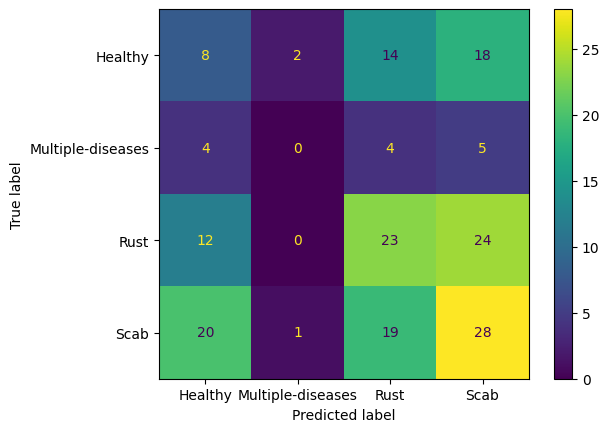

In [ ]:
disp.plot()

In [ ]:
precision_metric = precision_score(actual_labels, predict_labels, average = "macro")

recall_metric = recall_score(actual_labels, predict_labels, average = "macro")

accuracy_metric = accuracy_score(actual_labels, predict_labels)

f1_metric = f1_score(actual_labels, predict_labels, average = "macro")

In [ ]:
print("Precision Score : ", precision_metric)
print("Recall Score : ", recall_metric)
print("Accuracy Score", accuracy_metric)
print("F1 Score", f1_metric)

Precision Score :  0.23462121212121212
Recall Score :  0.24801785120827993
Accuracy Score 0.3241758241758242
F1 Score 0.24105238127125952
